In [8]:
import numpy as np
import matplotlib.pyplot as plt

**Thermal network parameters**

In [9]:
dt = 0.0001              # 100 µs timestep
duration = 10.0          # seconds
time = np.arange(0, duration, dt)
R1 = 100.0               # CPU->SoC (K/W)
R2 = 300.0               # SoC->Board
R3 = 60.0                # Board->Ambient
R4 = 30.0                # SoC->Package
R5 = 30.0                # Package->Ambient
C_cpu = 0.005            # J/°C
C_board = 3.0            # J/°C
C_pkg = 5.0              # J/°C
C_soc = 0.005            # (assumed equal to CPU)
T_amb = 25.0             # °C ambient
pleak = 0.1              # W leakage at nominal
V_max = V_nom = 0.75     # nominal voltage (V)
f_max = f_nom = 2.0      # nominal freq (GHz)
V_min = 0.55
f_min = 0.4              # linear scaling
temp_limit = 85.0        # °C threshold

**Synthetic dynamic-power trace in W/Ghz**

In [10]:
np.random.seed(0)
cdyn_trace = np.random.uniform(0.1, 1.0, len(time))

**Converting frequency to voltage using linear scaling**

In [11]:
def calculate_voltage(f):
    return (f + 4.0) / 8.0

**step thermal update given current temps and power**

In [12]:
def thermal_step(T_cpu, T_soc, T_board, T_pkg, P_cpu):
    # heat flow from CPU to SoC
    Q1 = (T_cpu - T_soc)/R1

    # SoC to board and package
    Q2 = (T_soc - T_board)/R2
    Q4 = (T_soc - T_pkg)/R4

    # board to ambient
    Q3 = (T_board - T_amb)/R3

    # package to ambient
    Q5 = (T_pkg - T_amb)/R5

    # temperature derivatives
    dT_cpu_dt = (-Q1 + P_cpu) / C_cpu
    dT_soc_dt = (Q1 - Q2 - Q4) / C_soc
    dT_board_dt = (Q2 - Q3) / C_board
    dT_pkg_dt = (Q4 - Q5) / C_pkg

    # integrate
    T_cpu_new = T_cpu + dT_cpu_dt * dt
    T_soc_new = T_soc + dT_soc_dt * dt
    T_board_new = T_board + dT_board_dt * dt
    T_pkg_new = T_pkg + dT_pkg_dt * dt
    return T_cpu_new, T_soc_new, T_board_new, T_pkg_new

**Simulation arrays**

In [27]:
# Initialization of temperature arrays
Tcpu_free = np.zeros_like(time)
Tcpu_thr = np.zeros_like(time)
Tcpu_pid = np.zeros_like(time)
Tcpu_free[:] = Tcpu_thr[:] = Tcpu_pid[:] = T_amb

Tsoc_free = Tsoc_thr = Tsoc_pid = T_amb
Tboard_free = Tboard_thr = Tboard_pid = T_amb
Tpkg_free = Tpkg_thr = Tpkg_pid = T_amb

# Initialization of V and f for DVFS
V_thr = np.full_like(time, V_nom)
f_thr = np.full_like(time, f_nom)

V_pid = np.full_like(time, V_nom)
f_pid = np.full_like(time, f_nom)


P_free = np.zeros_like(time)
P_thr = np.zeros_like(time)
P_pid = np.zeros_like(time)

**PID controller state**

In [28]:
Kp = 0.5; Ki = 0.1; Kd = 0.01
integral = 0.0
last_error = 0.0
pid_setpoint = temp_limit - 5.0  # 5°C below temperature limit

**Main simulation loop**

In [29]:
for i in range(1, len(time)):
    # Free-running
    V_free = V_nom
    f_free = f_nom
    P_dyn = cdyn_trace[i-1] * f_free
    P_cpu = P_dyn + pleak
    P_free[i] = P_cpu
    Tcpu_free[i], Tsoc_free, Tboard_free, Tpkg_free = thermal_step(Tcpu_free[i-1], Tsoc_free, Tboard_free, Tpkg_free, P_cpu)

    # Simple threshold DVFS
    if Tcpu_thr[i-1] > temp_limit:
        V_thr[i] = V_min
        f_thr[i] = f_min
    elif Tcpu_thr[i-1] < temp_limit - 5.0:  # Cool by 5°C before restoring nominal
        V_thr[i] = V_nom
        f_thr[i] = f_nom
    else:
        V_thr[i] = V_thr[i-1]
        f_thr[i] = f_thr[i-1]
    P_dyn = cdyn_trace[i-1] * f_thr[i]
    P_cpu = P_dyn + pleak
    P_thr[i] = P_cpu
    Tcpu_thr[i], Tsoc_thr, Tboard_thr, Tpkg_thr = thermal_step(Tcpu_thr[i-1], Tsoc_thr, Tboard_thr, Tpkg_thr, P_cpu)

    # PID DVFS
    error = Tcpu_pid[i-1] - pid_setpoint
    integral += error * dt
    derivative = (error - last_error)/dt if i>1 else 0.0
    control = Kp*error + Ki*integral + Kd*derivative
    f_new = f_pid[i-1] - control
    f_new = max(min(f_new, f_nom), f_min)
    f_pid[i] = f_new
    V_pid[i] = calculate_voltage(f_pid[i])
    P_dyn = cdyn_trace[i-1] * f_pid[i]
    P_cpu = P_dyn + pleak
    P_pid[i] = P_cpu
    Tcpu_pid[i], Tsoc_pid, Tboard_pid, Tpkg_pid = thermal_step(Tcpu_pid[i-1], Tsoc_pid, Tboard_pid, Tpkg_pid, P_cpu)
    last_error = error

**Plot (Temperature vs Time)**

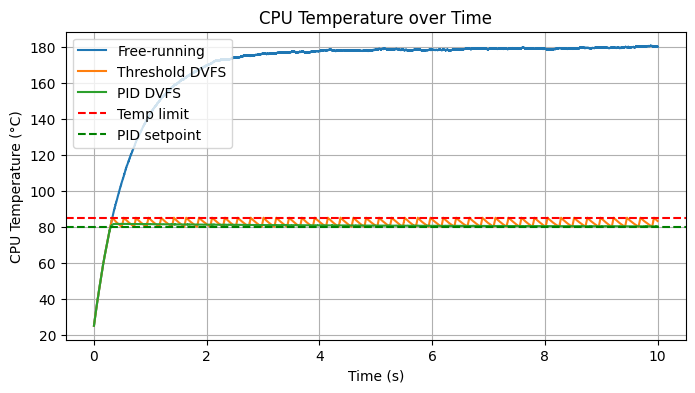

In [30]:
plt.figure(figsize=(8,4))
plt.plot(time, Tcpu_free, label='Free-running')
plt.plot(time, Tcpu_thr, label='Threshold DVFS')
plt.plot(time, Tcpu_pid, label='PID DVFS')
plt.axhline(temp_limit, color='r', linestyle='--', label='Temp limit')
plt.axhline(pid_setpoint, color='g', linestyle='--', label='PID setpoint')
plt.xlabel('Time (s)')
plt.ylabel('CPU Temperature (°C)')
plt.legend()
plt.title('CPU Temperature over Time')
plt.grid(True)
plt.show()

**Plot DVFS signals (Voltage vs Time)**

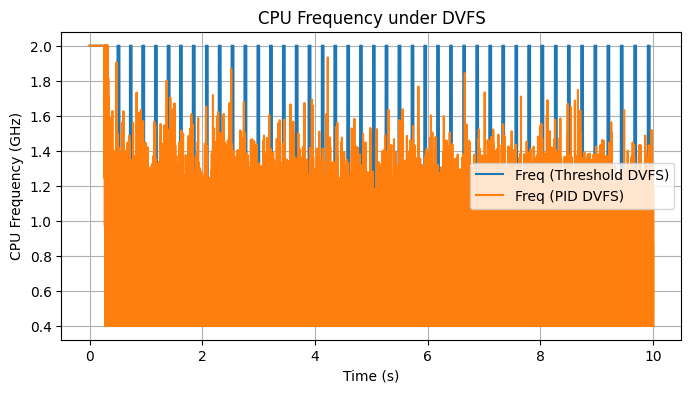

In [31]:
plt.figure(figsize=(8,4))
plt.plot(time, f_thr, label='Freq (Threshold DVFS)')
plt.plot(time, f_pid, label='Freq (PID DVFS)')
plt.xlabel('Time (s)')
plt.ylabel('CPU Frequency (GHz)')
plt.legend()
plt.title('CPU Frequency under DVFS')
plt.grid(True)
plt.show()

**Plot DVFS signals (Frequency vs Time)**

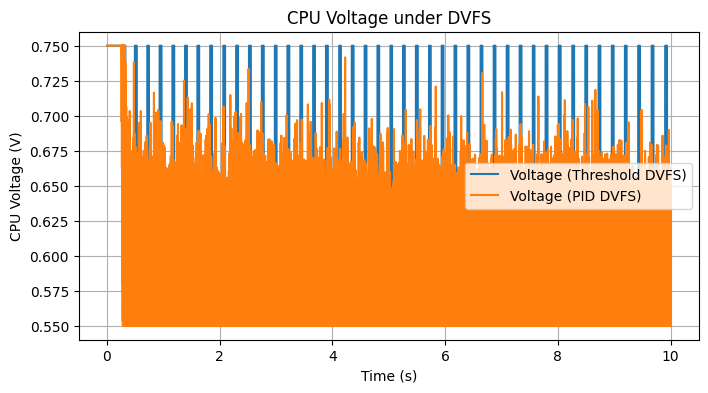

In [32]:
plt.figure(figsize=(8,4))
plt.plot(time, V_thr, label='Voltage (Threshold DVFS)')
plt.plot(time, V_pid, label='Voltage (PID DVFS)')
plt.xlabel('Time (s)')
plt.ylabel('CPU Voltage (V)')
plt.legend()
plt.title('CPU Voltage under DVFS')
plt.grid(True)
plt.show()

**Metrics Calculation**

In [35]:
import pandas as pd

# Metrics function
def compute_metrics(T, f=None, V=None, P=None, setpoint=83.0, dt=1e-4, duration=10.0):
    peak = np.nanmax(T)
    avg = np.nanmean(T)
    std = np.nanstd(T)
    osc = peak - np.nanmin(T)
    overshoot = peak - setpoint if peak > setpoint else 0
    metrics = {
        'Max Temp (°C)': round(peak, 2),
        'Avg Temp (°C)': round(avg, 2),
        'Temp Std Dev (°C)': round(std, 2),
        'Temp Oscillation (°C)': round(osc, 2),
        'Overshoot (°C)': round(overshoot, 2)
    }
    if f is not None:
        avg_f = np.nanmean(f)
        min_f = np.nanmin(f)
        throttle_pct = 100.0 * np.sum(f < np.nanmax(f)) / len(f)
        metrics.update({
            'Avg Freq (GHz)': round(avg_f, 2),
            'Min Freq (GHz)': round(min_f, 2),
            'Throttle Time (%)': round(throttle_pct, 1)
        })
    if V is not None:
        avg_V = np.nanmean(V)
        volt_changes = np.sum(np.diff(V) != 0)
        metrics.update({
            'Avg Voltage (V)': round(avg_V, 3),
            'Voltage Changes (count)': int(volt_changes)
        })
    if P is not None:
        total_energy = np.nansum(P) * dt
        avg_power = np.nanmean(P)
        edp = total_energy * duration
        metrics.update({
            'Total Energy (J)': round(total_energy, 2),
            'Avg Power (W)': round(avg_power, 2),
            'Energy-Delay Product': round(edp, 2)
        })
    return metrics

# Metrics for each mode
metrics_free = compute_metrics(Tcpu_free, P=P_free)
metrics_thr  = compute_metrics(Tcpu_thr, f_thr, V_thr, P_thr)
metrics_pid  = compute_metrics(Tcpu_pid, f_pid, V_pid, P_pid)

# DataFrame
df_metrics = pd.DataFrame({
    'Free-running': metrics_free,
    'Threshold DVFS': metrics_thr,
    'PID DVFS': metrics_pid
}).T

print("\n===== Performance and Energy Metrics =====\n")
print(df_metrics.to_string())


===== Performance and Energy Metrics =====

                Max Temp (°C)  Avg Temp (°C)  Temp Std Dev (°C)  Temp Oscillation (°C)  Overshoot (°C)  Total Energy (J)  Avg Power (W)  Energy-Delay Product  Avg Freq (GHz)  Min Freq (GHz)  Throttle Time (%)  Avg Voltage (V)  Voltage Changes (count)
Free-running           180.61         168.11              26.22                 155.61           97.61             11.99           1.20                119.91             NaN             NaN                NaN              NaN                      NaN
Threshold DVFS          85.03          81.57               5.58                  60.03            2.03              4.72           0.47                 47.22            0.68             0.4               82.8            0.584                     85.0
PID DVFS                81.61          79.97               5.17                  56.61            0.00              4.58           0.46                 45.81            0.65             0.4             